# STDP

Download the Jupyter notebook: [STDP.ipynb](https://raw.githubusercontent.com/ANNarchy/tutorial/master/src/notebooks/STDP.ipynb){target="_blank"}

Run it directly on colab: [STDP.ipynb](https://colab.research.google.com/github/ANNarchy/tutorial/blob/master/src/notebooks/STDP.ipynb){target="_blank"}

This notebook demonstrates the online implementation of the spike time-dependent plasticity rule.

In [ ]:
!pip install ANNarchy

In [1]:
from ANNarchy import *
clear()
setup(dt=1.0)

ANNarchy 4.7 (4.7.1.5) on darwin (posix).


The STDP learning rule maintains exponentially-decaying traces for the pre-synaptic and post-synaptic spikes.

$$\tau^+ \, \frac{d x(t)}{dt} = -x (t)$$

$$\tau^- \, \frac{d y(t)}{dt} = -x (t)$$

LTP and LTD occur at spike times depending on the corresponding traces.

* When a pre-synaptic spike occurs, $x(t)$ is incremented and **LTD** is applied proportionally to $y(t)$.
* When a post-synaptic spike occurs, $y(t)$ is incremented and **LTP** is applied proportionally to $x(t)$.
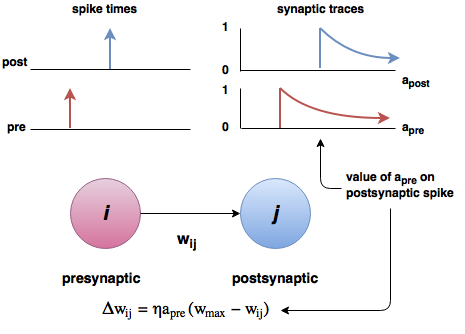

In [2]:
STDP = Synapse(
    parameters = """
        tau_plus = 20.0 : projection ; tau_minus = 20.0 : projection
        A_plus = 0.01 : projection   ; A_minus = 0.01 : projection
        w_min = 0.0 : projection     ; w_max = 2.0 : projection
    """,
    equations = """
    
        tau_plus * dx/dt = -x : event-driven # pre-synaptic trace
    
        tau_minus * dy/dt = -y : event-driven # post-synaptic trace
    
    """,
    pre_spike="""
        
        g_target += w
        
        x += A_plus * w_max
        
        w = clip(w - y, w_min , w_max) # LTD
    """,
    post_spike="""
        
        y += A_minus * w_max
        
        w = clip(w + x, w_min , w_max) # LTP
    """
)

We create two dummy populations with one neuron each, whose spike times we can control.

In [3]:
pre = SpikeSourceArray([[0.]])
post = SpikeSourceArray([[50.]])

We connect the population using a STDP synapse.

In [4]:
proj = Projection(pre, post, 'exc', STDP)
proj.connect_all_to_all(1.0)

In [5]:
compile()

Compiling ...  OK 


The presynaptic neuron will fire at avrious times between 0 and 100 ms, while the postsynaptic neuron keeps firing at 50 ms.

In [6]:
pre_times = np.linspace(100.0, 0.0, 101)

In [7]:
weight_changes = []
for t_pre in pre_times:
    
    # Reset the populations
    pre.clear()
    post.clear()
    pre.spike_times = [[t_pre]]
    post.spike_times = [[50.0]]
    
    # Reset the traces
    proj.x = 0.0
    proj.y = 0.0
    
    # Weight before the simulation
    w_before = proj[0].w[0]
    
    # Simulate long enough
    simulate(105.0)
    
    # Record weight change
    delta_w = proj[0].w[0] - w_before
    weight_changes.append(delta_w)

We can now plot the classical STDP figure:

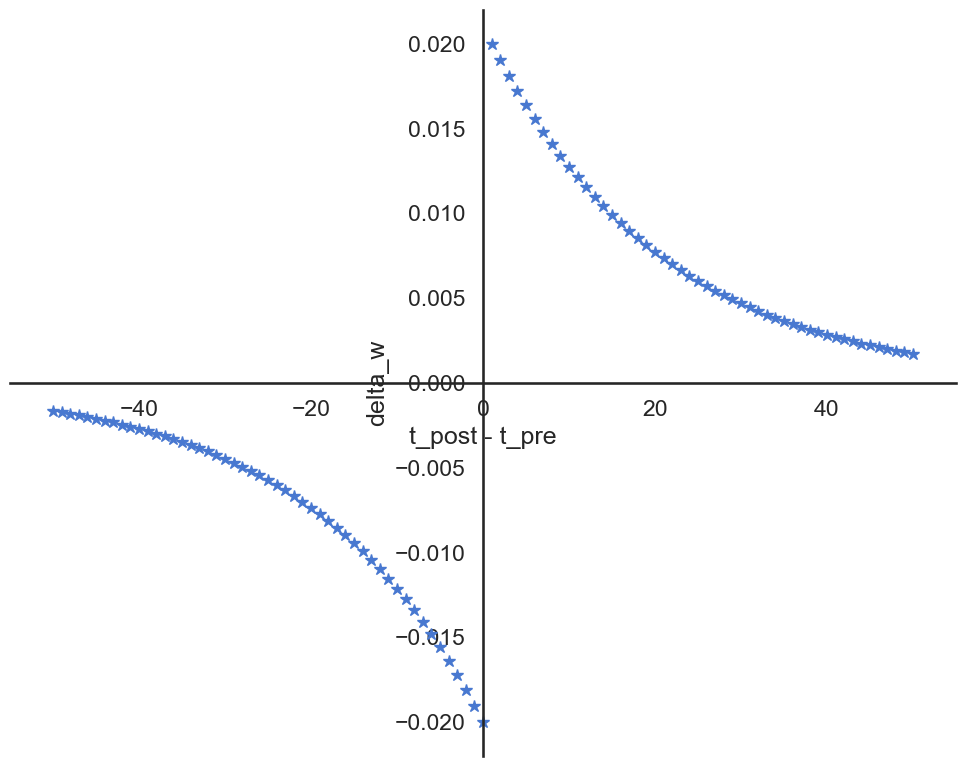

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("talk")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
plt.plot(50. - pre_times, weight_changes, "*")
plt.xlabel("t_post - t_pre")
plt.ylabel("delta_w")

sns.despine()

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
plt.tight_layout()
plt.show()